In [ ]:
#import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as bknd
import os
import math

from google.colab import drive
!pip install -q pyyaml h5py

tf.__version__

'2.5.0'

In [ ]:
#bknd.clip( -1.1, -1, 1)
#binary_hard_tanh(-10)
int(0.9)

0

In [ ]:
#--------------------------------------
# Binary layer definition 
#--------------------------------------

# Activation function 
def binary_hard_tanh(x):
  #return bknd.round( bknd.clip(x, -1, 1) )
  #return ( bknd.clip(x, -1, 1) )
  #return 2.*round_through( hard_sigmoid(x) ) - 1
  return round_through( hard_sigmoid(x) )               # keep activation {0, 1}

def round_through(x):
  rounded = tf.round(x)
  return x + tf.stop_gradient(rounded - x)

def hard_sigmoid(x):
  return bknd.clip( (x+1.)/2., 0, 1)

def sign_function(x):
  x2 = np.clip( (x+1.)/2. , 0, 1)
  return np.around(x2)

def sign_ineq(x, limit):
  #if x > -limit:
  a = -limit
  if x > a :
    if (x-a) <= 1:
      print("x =  ", x)
      print("limit =  ", a)  
    return 1
  else:
    return 0

def sign_ineq2(x, limit):
  #if limit >= 0:
  if limit > 0:
    #a = -2
    return 1
  else:
    a = (-1) * int(limit)

  if x > a :
    # if (x-a) <= 1:
    #   print("x =  ", x)
    #   print("limit =  ", limit)  
    return 1
  else:
    return 0

def act_round(x):
  return x + tf.stop_gradient( tf.math.round(x) - x )

'''
def sign_function(x):
  return 2.*round_through( bknd.clip(x, 0, 1) ) - 1
'''
'''
def sign_function(x):
  #if x >= 0:
  if x > 0:
    return 1
  else: 
    return -1
'''

# Convolution binary layer
class Conv2D_BinaryLayer(tf.keras.layers.Layer):

  def __init__(self, filters=32, kernel_size=(3,3), strides=[1,1,1,1], padding="VALID", H=1.0, use_bias=False, **kwargs):
    super(Conv2D_BinaryLayer, self).__init__(**kwargs);
    self.filters  = filters;  self.kernel_size = kernel_size;
    self.strides  = strides;  self.padding     = padding;
    self.H        = H;        self.use_bias    = use_bias;

  def build(self, input_shape):
    # NHWC format --> input_shape[-1] == "channels_last"
    input_dim    = input_shape[-1];
    kernel_shape = tuple(self.kernel_size) + (input_dim, self.filters);
    self.kernel  = self.add_weight(shape       = kernel_shape,
                                   initializer = tf.keras.initializers.RandomUniform(-self.H, self.H),
                                   name        = "kernel",
                                   regularizer = None,
                                   #constraint  = lambda w: tf.math.round( tf.clip_by_value(w, -self.H, self.H) ),
                                   constraint  = lambda w: tf.math.round( tf.clip_by_value(w, 0, self.H) ),
                                   trainable   = True);

    if self.use_bias:
      self.bias = self.add_weight( shape       = (self.filters, ),
                                   initializer = tf.keras.initializers.Zeros,
                                   name        = "bias",
                                   regularizer = None,
                                   #constraint  = lambda w: tf.math.round( tf.clip_by_value(w, -self.H, self.H) ),
                                   constraint  = lambda w: tf.math.round( tf.clip_by_value(w, 0, self.H) ),
                                   trainable   = True);
    else:
      self.bias = None;

    self.k_bin = 0;                                        # Kernels binaires

  def call(self, inputs):
    self.k_bin = self.kernel;
    outputs    = tf.nn.conv2d(inputs, self.k_bin, strides=self.strides, padding=self.padding);
    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.bias);
    return outputs;

  def get_config(self):
    config = super().get_config().copy();
    config.update({
      "filters": self.filters, "kernel_size": self.kernel_size, "strides": self.strides,
      "padding": self.padding, "H": self.H, "use_bias": self.use_bias });
    return config;


class Dense_BinaryLayer(tf.keras.layers.Layer):
  def __init__(self, units=32, H=1.0, use_bias=False, **kwargs):
    super(Dense_BinaryLayer, self).__init__(**kwargs);
    self.units    = units;    self.H = H;
    self.use_bias = use_bias;

  def build(self, input_shape):
    # NHWC format --> input_shape[-1] == "channels_last"
    input_dim    = input_shape[-1];
    self.w = self.add_weight( shape       = (input_dim, self.units),
                              initializer = tf.keras.initializers.RandomUniform(-self.H, self.H),
                              name        = "kernel",
                              regularizer = None,
                              #constraint  = lambda w: tf.math.round( tf.clip_by_value(w, -self.H, self.H) ),
                              constraint  = lambda w: tf.math.round( tf.clip_by_value(w, 0, self.H) ),
                              trainable   = True);
    if self.use_bias:
      self.bias = self.add_weight( shape       = (self.units, ),
                                   initializer = tf.keras.initializers.Zeros,
                                   name        = "bias",
                                   regularizer = None,
                                   #constraint  = lambda w: tf.math.round( tf.clip_by_value(w, -self.H, self.H) ),
                                   constraint  = lambda w: tf.math.round( tf.clip_by_value(w, 0, self.H) ),
                                   trainable   = True);
    else:
      self.bias = None;

    self.w_bin = 0;                                        # Weights binaires

  def call(self, inputs):
    self.w_bin = self.w;                                   # Binarization du weights
    outputs = tf.matmul(inputs, self.w_bin);
    if self.use_bias:
      outputs = tf.nn.bias_add(outputs, self.bias);
    return outputs;

  def get_config(self):
    config = super().get_config().copy();
    config.update({
      "units": self.units,  "H": self.H, "use_bias": self.use_bias });
    return config;

In [ ]:
l = -255.4

if l >= 0:
    a = 0
else:
    a = (-1) * int(l)

print(a)

255


## **Dataset: MNIST**

11493376/11490434 [==============================] - 0s 0us/step


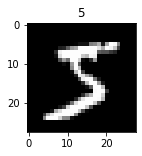

In [ ]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

valid_img = test_images[0:5000]
valid_label = test_labels[0:5000]
test_images = test_images[5000:10000]
test_labels = test_labels[5000:10000]
  
# Vizualize one img sample
fig = plt.figure(figsize=(2,2));
plt.imshow(train_images[0], cmap="gray", interpolation=None);
plt.title( train_labels[0] );  

Normalize Dataset

In [ ]:
scale_norm = 113.

valid_img = np.round( (valid_img/255.)*scale_norm )
test_images = np.round( (test_images/255.)*scale_norm )
train_images = np.round( (train_images/255.)*scale_norm )

print(valid_img.shape)
print(np.amax(valid_img))
print(np.amin(valid_img))

(5000, 28, 28)
113.0
0.0


In [ ]:
scale_norm = 254.
mov = 127

valid_img = np.round( ((valid_img/255.)*scale_norm) - mov )
test_images = np.round( ((test_images/255.)*scale_norm) - mov )
train_images = np.round( ((train_images/255.)*scale_norm) - mov )

print(valid_img.shape)
print(np.amax(valid_img))
print(np.amin(valid_img))

(5000, 28, 28)
127.0
-127.0


Sort the Data

In [ ]:
# Prepare training data
batch_size = 1000

valid_data = tf.data.Dataset.from_tensor_slices((valid_img, valid_label))
valid_data = valid_data.shuffle(len(valid_img))
valid_data = valid_data.batch(batch_size)
valid_data = valid_data.prefetch(1)

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_data = train_data.shuffle(len(test_images))
train_data = train_data.batch(batch_size)
train_data= train_data.prefetch(1)

In [ ]:
print(valid_data)
print(train_data)
print(np.amax(valid_img))
print(np.amin(valid_img))

<PrefetchDataset shapes: ((None, 28, 28), (None,)), types: (tf.uint8, tf.uint8)>
<PrefetchDataset shapes: ((None, 28, 28), (None,)), types: (tf.uint8, tf.uint8)>
255
0


Valid image Sample
Verify label
5


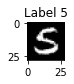

In [ ]:
valData = valid_data.take(1)
#testData = test_data.take(1)

i=1
print("Valid image Sample")
for image, label in valData: 
  plt.subplot(5,5,i), plt.imshow(np.squeeze(image[i]), cmap='gray'), plt.title('Label '+str(label[i].numpy()))

print("Verify label")
print(label[1].numpy())

# **Reference BNN Model**

Characteristics:


*   Input: range [0 - 255] one channel
*   Weights: Binary
*   Activation: Binary



In [ ]:
# Weigths and Activitions are constrain to {0, +H} values 
H = 1.0;

# Init parameters to BatchNormalization Layer
alpha = 0.1; epsilon = 1.0e-4;

model = tf.keras.Sequential( [
  tf.keras.layers.InputLayer( input_shape=(28, 28) ),
  tf.keras.layers.Reshape( target_shape=(28, 28, 1) ),

  Conv2D_BinaryLayer(filters=12, H=H, use_bias=True ),
  tf.keras.layers.MaxPooling2D( (2,2) ),  
  
  tf.keras.layers.Flatten(),
  tf.keras.layers.BatchNormalization(),                                              
  tf.keras.layers.Activation(binary_hard_tanh),

  Dense_BinaryLayer( 10, H=H, use_bias=True ) ]);

model.summary();

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d__binary_layer (Conv2D (None, 26, 26, 12)        120       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 12)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2028)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2028)              8112      
_________________________________________________________________
activation (Activation)      (None, 2028)              0         
_________________________________________________________________
dense__binary_layer (Dense_B (None, 10)               

In [ ]:
epochs = 550;

# Init. Adam optimizer with decay Learning rate
lr_start = 1e-3; lr_end = 1e-7;
lr_decay = (lr_end / lr_start)**(1./epochs);
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr_start,
                                                             decay_steps=1000,
                                                             decay_rate=lr_decay,
                                                             staircase=True);
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule);


model.compile( optimizer=opt,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=["accuracy"] ); 

# Training Model
model.fit( train_data, epochs=epochs, validation_data=valid_data, batch_size=batch_size);

# Model evaluation with Test images
model_error, model_accuracy = model.evaluate( test_images, test_labels, verbose=0 );
print("\nMODEL EVALUATION")
print("Model Accuracy: ", model_accuracy);
print("Model Error: ", model_error);

Epoch 1/550
60/60 [==============================] - 1s 12ms/step - loss: 17.9845 - accuracy: 0.1037 - val_loss: 27.2852 - val_accuracy: 0.1206
Epoch 2/550
60/60 [==============================] - 1s 9ms/step - loss: 11.3297 - accuracy: 0.0935 - val_loss: 25.6580 - val_accuracy: 0.1136
Epoch 3/550
60/60 [==============================] - 1s 9ms/step - loss: 11.7108 - accuracy: 0.0947 - val_loss: 23.4287 - val_accuracy: 0.1030
Epoch 4/550
60/60 [==============================] - 1s 9ms/step - loss: 11.4902 - accuracy: 0.0963 - val_loss: 21.6316 - val_accuracy: 0.1006
Epoch 5/550
60/60 [==============================] - 1s 9ms/step - loss: 11.0820 - accuracy: 0.0966 - val_loss: 23.9128 - val_accuracy: 0.1024
Epoch 6/550
60/60 [==============================] - 1s 9ms/step - loss: 11.3623 - accuracy: 0.1009 - val_loss: 20.7629 - val_accuracy: 0.0938
Epoch 7/550
60/60 [==============================] - 1s 10ms/step - loss: 11.4544 - accuracy: 0.1033 - val_loss: 22.8068 - val_accuracy: 0.11

KeyboardInterrupt: ignored

## **Load saving Model**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.flush_and_unmount()

Saving Model

In [ ]:
PATH_MODEL = '/content/drive/MyDrive/IA/tesis/code/BNN_test/save_models/'
#PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_sinGamma/saved_model/binary_actW'                 # Exactly the same prediction array numbers 84% input 255
#PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_sG_round/saved_model/binary_actW'                # 82%   in:255  
PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_sG_roundConvMax/saved_model/binary_actW'                # 85%   in:255  
#PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_roundConvMax_in113/saved_model/binary_sG_actW'                # 84.8%   in:113
#PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_roundConvMax_in127/saved_model/binary_sG_actW'                # 87.3%   in: [-127, 127]  

#PATH_ENTIRE_MODEL = PATH_MODEL + 'reference_model/saved_model/entire_model_binary'
#PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_model_eZero/saved_model/entire_binary_act'
#PATH_ENTIRE_MODEL = PATH_MODEL + 'bnn_model/saved_model/entire_binary_actToo'           # 88%

#PATH_ENTIRE_MODEL = PATH_MODEL + 'reference_model/saved_model/entire_model_binary'
#PATH_ENTIRE_MODEL = PATH_MODEL + 'binary_model/saved_model/entire_model_binary'
#PATH_ENTIRE_MODEL = PATH_MODEL + 'saved_model/entire_model'

#PATH_WEIGHTS = PATH_MODEL + '/bnn_ref_weights.h5'

print(PATH_ENTIRE_MODEL)

/content/drive/MyDrive/IA/tesis/code/BNN_test/save_models/bnn_sG_roundConvMax/saved_model/binary_actW


**save model** (take care)

In [ ]:
# Save the entire model as a SavedModel.
model.save(PATH_ENTIRE_MODEL)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/IA/tesis/code/BNN_test/save_models/bnn_sG_round/saved_model/binary_actW/assets


Loading Model

In [ ]:
model_loaded = tf.keras.models.load_model(PATH_ENTIRE_MODEL)

# Show the model architecture
model_loaded.summary()

# Evaluate the restored model
loss, acc = model_loaded.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d__binary_layer (Conv2D (None, 26, 26, 12)        120       
_________________________________________________________________
activation (Activation)      (None, 26, 26, 12)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 12)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 12)        0         
_________________________________________________________________
flatten (Flatten)            (None, 2028)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2028)              6

# **Check layers Weights**

In [ ]:
print("LAYER WEIGHTS           ")
print("**************************************")

#for layer in model.layers:
for layer in model_loaded.layers:
  print("\n\n NEW LAYER           ")
  print("************************************** ")
  print( "Layer: ", layer )
  print( "Layer config.: ", layer.get_config() )
  print( "Layer WIEGTS: ", layer.get_weights() )

LAYER WEIGHTS           
**************************************


 NEW LAYER           
************************************** 
Layer:  <tensorflow.python.keras.layers.core.Reshape object at 0x7f37b0e0af90>
Layer config.:  {'name': 'reshape', 'trainable': True, 'dtype': 'float32', 'target_shape': (28, 28, 1)}
Layer WIEGTS:  []


 NEW LAYER           
************************************** 
Layer:  <tensorflow.python.keras.saving.saved_model.load.Conv2D_BinaryLayer object at 0x7f3764139f10>
Layer config.:  {'name': 'conv2d__binary_layer', 'trainable': True, 'dtype': 'float32', 'filters': 12, 'kernel_size': (3, 3), 'strides': [1, 1, 1, 1], 'padding': 'VALID', 'H': 1.0, 'use_bias': True}
Layer WIEGTS:  [array([[[[0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.]],

        [[1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.]]],


       [[[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1.]],

        [[0., 1., 0., 0., 1., 0., 0., 1., 1.

# **Check layer Outputs**

(5000, 28, 28)


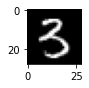

In [ ]:
img_choosen = 0

print(test_images.shape)
plt.figure(figsize=(1,1))
plt.imshow(np.squeeze(test_images[img_choosen,:,:]), cmap='gray')

In [ ]:
img_test = test_images[img_choosen,:,:]
print( img_test.shape )
img_test = np.expand_dims( img_test, axis=0 )
print( img_test.shape)

# Model Validation
print(test_labels[img_choosen])
model_loaded.predict( img_test )

(28, 28)
(1, 28, 28)
3


array([[285., 280., 282., 291., 278., 294., 271., 275., 290., 273.]],
      dtype=float32)

In [ ]:
print(test_images.shape)
print(np.amax(test_images))
print(np.amin(test_images))
print(np.amin(test_images[143,:,:].shape))

(5000, 28, 28)
255
0
28


In [ ]:
#USE IT
#Check BNN's Layers Outputs 
outputs = []
i = 0
model_work = model_loaded
#model_work = model

for layer in model_work.layers:
    keras_function = bknd.function([model_work.input], [layer.output])
    #outputs.append(keras_function([img_test]))
    outputs.append(keras_function(test_images))
    np_output = np.array(outputs[i])
    shape_output = np_output.shape
    max_output = np.amax(np_output)
    min_output = np.amin(np_output)
    print("\n New Output Layer")
    print("_______________________")
    print("Layer: ", layer)
    print("Shape output: ", shape_output)
    print("Max. Value: ", max_output)
    print("Min. Value: ", min_output)
    print(outputs[i])
    i = 1 + i

#print(outputs)


 New Output Layer
_______________________
Layer:  <tensorflow.python.keras.layers.core.Reshape object at 0x7f37b0e0af90>
Shape output:  (1, 5000, 28, 28, 1)
Max. Value:  255.0
Min. Value:  0.0
[array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        ...,

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]]],


       [[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
  

In [ ]:
np.array(outputs[0]).shape

(1, 5000, 28, 28, 1)

## **Simplifing  BatchNorm parameters**

In [ ]:
#USE IT
btn_layer  = model_work.get_layer(name='batch_normalization')
btn_weights = btn_layer.get_weights()
btna_weights = np.array(btn_weights)

print('Batch Weights')
print(btna_weights.shape)
print(tf.shape(btn_weights))
print(btn_weights)

Batch Weights
(3, 2028)
tf.Tensor([   3 2028], shape=(2,), dtype=int32)
[array([-0.00600527, -0.00600518,  0.00600535, ...,  0.00600519,
       -0.18293215, -0.10465011], dtype=float32), array([0.00197944, 0.00117556, 0.00970082, ..., 0.02397482, 0.00515459,
       0.14687474], dtype=float32), array([ 0.09393841,  0.0751605 ,  0.88233954, ...,  4.7221484 ,
        0.54187244, 32.885727  ], dtype=float32)]


In [ ]:
btna_weights[:, 0]

array([-0.00600527,  0.00197944,  0.09393841], dtype=float32)

In [ ]:
btna_weights[1, 0]

0.0019794442

### Reference: Deep Learning BNN [1]

In [ ]:
number = 0.1
print(sign_function(number))
print(binary_hard_tanh(number))
print(np.around(0.505))  # clipping of 1 is 0.505

1.0
tf.Tensor(1.0, shape=(), dtype=float32)
1.0


**own:** Prepare data to replace batchNorm layer

In [ ]:
#USE IT
len_parameters = 2028
new_batch = []

for j in range(len_parameters):
  beta =  btna_weights[0, j]
  mean =  btna_weights[1, j]
  var =   btna_weights[2, j]

  var = math.sqrt( var+0.001 )

  r = beta - ( mean/var )
  v = var
  new_batch.append( np.array([r, v]) )

print( len(new_batch) )

2028


own with Gamma

In [ ]:
len_parameters = 2028
new_batch = []

for j in range(len_parameters):
  gamma =   btna_weights[0, j]
  beta =   btna_weights[1, j]
  mean =   btna_weights[2, j]
  var =    btna_weights[3, j]

  var = math.sqrt( var+0.001 )

  r = ( (beta*var)/gamma ) - ( mean )
  v = gamma/var
  new_batch.append( np.array([r, v]) )

print( len(new_batch) )

IndexError: ignored

In [ ]:
print(new_batch[0])
print(new_batch[0][1])


**paper [1]**

In [ ]:
len_parameters = 2028
new_batch = []

for j in range(len_parameters):
  gamma = btna_weights[0, j]
  beta =  btna_weights[1, j]
  mean =  btna_weights[2, j]
  var =   btna_weights[3, j]

  var = math.sqrt( var+0.001 )

  p = ( (beta*var)/gamma ) - mean
  q = sign_function( (gamma/var) )
  new_batch.append( np.array([p, q]) )

print( len(new_batch) )

In [ ]:
print(new_batch[0])
print(new_batch[0][1])
print(new_batch[0][0])
print(new_batch[1])
print(new_batch[1][0])

In [ ]:
print(np.array( outputs[3] ).shape)  # Flatten layer
outputs[3][0][0][0]

**own**

All the test dataset

In [ ]:
#USE IT
print(np.array(outputs[3]).shape)
print(np.array(outputs[4]).shape)
print(test_labels.shape)
print("____________")

out_newBatch = np.zeros(2028*5000)
out_newBatch = out_newBatch.reshape(5000, 2028)
#out_newBatch = np.zeros(2028)

print(out_newBatch.shape)
print(out_newBatch[0, 2027])
#print(out_newBatch[0,0,2027])

(1, 5000, 13, 13, 12)
(1, 5000, 13, 13, 12)
(5000,)
____________
(5000, 2028)
0.0



All the test dataset: Replace BatchNorm layer

In [ ]:
# USE THIS
s_np = np.zeros(2028)
t_np = np.zeros(2028) 
lit = np.zeros(2028) 

for j in range(5000):
  for i in range(len_parameters):
    s = sign_function(1./new_batch[i][1])
    t = (new_batch[i][1]*new_batch[i][0])
    #out_newBatch[j, i] = s*sign_function( (outputs[5][0][j][i]) + (t) )                        # 4 Activation layer to became all in intigers
    #out_newBatch[j, i] = s*sign_ineq( (outputs[5][0][j][i]*10.), np.round(t*10.) )             # acc= 81.68%  
    #out_newBatch[j, i] = s*sign_ineq( (outputs[5][0][j][i]), t )                                # acc= 85.6% equal to the reference model 
    #out_newBatch[j, i] = s*sign_ineq2( (outputs[5][0][j][i]), t )                                # 85%
    out_newBatch[j, i] = sign_ineq2( (outputs[5][0][j][i]), t )                                # 85% the value of zeta after sign() always is 1 
    #lit[i] = np.round(t*+0.05)
    #out_newBatch[j, i] = s*sign_ineq( (outputs[5][0][j][i]), np.round(t*+0.05) )                # 52% and 19% with ( >= )
    #out_newBatch[j, i] = s*sign_function( (outputs[5][0][j][i]*10) + np.round(t*10) )          # 4 Activation layer to became all in intigers 81%
    #out_newBatch[j, i] = s*sign_function( (outputs[5][0][j][i]) + np.round(t+0.005) )         
    #out_newBatch[j, i] = s*sign_function( (outputs[3][0][j][i]) + (t) )
    #out_newBatch[j, i] = s*sign_function( (outputs[3][0][0][i]) + np.round(t) )
    #out_newBatch[j, i] = s*sign_ineq( (outputs[3][0][0][i]*1000.), np.round(t*1000.) )
    s_np[i] = s
    t_np[i] = t

print(out_newBatch.shape)
print(out_newBatch[0, 0])

(5000, 2028)
0.0


In [ ]:
int(-0.7)

0

In [ ]:
# USE THIS
print(np.amin(t_np))
print(np.amax(t_np))

-1857.258726152831
546.3191876319148


In [ ]:
a = np.copy(outputs[3][0][100][:])
b = np.copy(outputs[3][0][10][:])
print(a.shape)
print(t_np.shape)
print(np.subtract(a, b))
print("-------")
print(np.amax(a))
print(np.amin(a))

with np.printoptions(threshold=np.inf):
    print(
        np.subtract(a, t_np))

(2028,)
(2028,)
[-3.2548080e-05 -2.5398815e-05 -3.3327095e-05 ... -1.7434229e-05
  1.0512664e-05 -1.5367883e-05]
-------
1265.0
-3.4332275e-05
[ 6.74004927e-03  2.18005459e-03  4.89642781e-02  2.96039395e-03
 -1.24028478e-03 -1.38372591e-03 -5.24576127e-02  1.78294287e-02
 -6.93991302e-04  5.07620367e-03  1.77044440e-03 -1.74736782e-01
 -2.26164592e-01  1.68162803e-02 -1.21902610e-01  1.48054145e-03
  1.73439676e-02 -4.97919736e-03  1.78949752e-01  1.11080583e-03
  8.53508468e-02  3.58915629e-02  3.99855453e-02  6.47755774e-01
  1.94602725e+00 -2.55310898e-01  1.02849833e-01  7.57815231e-02
 -2.31940965e-02 -2.72156589e-01  3.58850402e-01 -1.19248084e+00
 -6.70619369e-01  2.17208769e-02 -1.92658051e-01 -1.35816845e+00
  5.83179288e+00 -3.78111873e-01 -4.81769382e-01 -4.06975468e-02
  3.51331121e-01  4.17209754e-01  1.48383156e+00 -2.44219480e+00
 -2.00372377e+00  3.01895764e+00  1.14458051e+00  5.93575810e+00
  8.60139891e+00  1.68589433e+00  1.86767692e+00  5.45742312e-01
  1.32375972

**one sample:** Replace BatchNorm layer

In [ ]:
#out_newBatch = np.expand_dims( np.zeros(2028), axis=(1,0))
out_newBatch = np.zeros(2028)

print(out_newBatch.shape)
print(out_newBatch[2027])
#print(out_newBatch[0,0,2027])
print("____________")

s_np = np.zeros(2028)
t_np = np.zeros(2028) 

for i in range(len_parameters):
  #out_newBatch[i] = ( (outputs[3][0][0][i]/new_batch[i][1]) + new_batch[i][0] )
  #out_newBatch[i] = (1/new_batch[i][1])*( (outputs[3][0][0][i]) + (new_batch[i][1]*new_batch[i][0]) )
  #out_newBatch[i] = sign_function( out_newBatch[i] )

  #out_newBatch[i] = sign_function(1/new_batch[i][1])*sign_function( (outputs[3][0][0][i]) + (new_batch[i][1]*new_batch[i][0]) )
  s = sign_function(1/new_batch[i][1])
  t = (new_batch[i][1]*new_batch[i][0])
  #out_newBatch[i] = s*sign_function( (outputs[3][0][0][i]) + np.round(t) )
  #out_newBatch[i] = s*sign_function( (outputs[3][0][0][i]) + t )                # Exactly the same prediction array numbers
  out_newBatch[i] = s*sign_ineq( (outputs[3][0][0][i]), t )                      # Exactly the same prediction array numbers Too
  #out_newBatch[i] = s*sign_ineq( (outputs[3][0][0][i]*10), np.round(t*10) )                      
  #out_newBatch[i] = s*sign_ineq( (outputs[3][0][0][i]), np.round(t) )                      
  
  s_np[i] = s
  t_np[i] = t

print(out_newBatch.shape)
print(out_newBatch[0])
#print(out_newBatch[0,0,0])

In [ ]:
print(np.amax(s_np))
print(np.amin(s_np))
print(np.amax(t_np))
print(np.round(np.amin(t_np)))

own with Gamma  **Not Usefull**

In [ ]:
#out_newBatch = np.expand_dims( np.zeros(2028), axis=(1,0))
out_newBatch = np.zeros(2028)

print(out_newBatch.shape)
print(out_newBatch[2027])
#print(out_newBatch[0,0,2027])
print("____________")

s_np = np.zeros(2028)
t_np = np.zeros(2028) 

for i in range(len_parameters):
  #out_newBatch[i] = ( (outputs[3][0][0][i]/new_batch[i][1]) + new_batch[i][0] )
  #out_newBatch[i] = (1/new_batch[i][1])*( (outputs[3][0][0][i]) + (new_batch[i][1]*new_batch[i][0]) )
  #out_newBatch[i] = sign_function( out_newBatch[i] )

  #out_newBatch[i] = sign_function(1/new_batch[i][1])*sign_function( (outputs[3][0][0][i]) + (new_batch[i][1]*new_batch[i][0]) )
  s = sign_function( new_batch[i][1] )
  t = ( new_batch[i][0] )
  #out_newBatch[i] = s*sign_function( (outputs[3][0][0][i]) + np.round(t) )
  out_newBatch[i] = s*sign_function( (outputs[3][0][0][i]) + t )                # Exactly the same prediction array numbers
  #out_newBatch[i] = s*sign_ineq( (outputs[3][0][0][i]), t )                      # Exactly the same prediction array numbers Too
  #out_newBatch[i] = s*sign_ineq( (outputs[3][0][0][i]*10), np.round(t*10) )                      
  #out_newBatch[i] = s*sign_ineq( (outputs[3][0][0][i]), np.round(t) )                      
  
  s_np[i] = s
  t_np[i] = t

print(out_newBatch.shape)
print(out_newBatch[0])
#print(out_newBatch[0,0,0])

In [ ]:
print(np.amax(s_np))
print(np.amin(s_np))
print(np.amax(t_np))
print(np.round(np.amin(t_np)))

Paper [1]

In [ ]:
#out_newBatch = np.expand_dims( np.zeros(2028), axis=(1,0))
out_newBatch = np.zeros(2028)

print(out_newBatch.shape)
print(out_newBatch[2027])
#print(out_newBatch[0,0,2027])
print("____________")


for i in range(len_parameters):
  out_newBatch[i] = (new_batch[i][1])*( outputs[3][0][0][i] + new_batch[i][0] )                   # Very bad  (it's necessary apply the sign function)
  #out_newBatch[i] = (new_batch[i][1])*sign_function( outputs[3][0][0][i] + new_batch[i][0] )
  out_newBatch[i] = sign_function( out_newBatch[i] )
  #out_newBatch[0,0,i] = (new_batch[i][1])*( outputs[3][0][0][i] + new_batch[i][0] )

print(out_newBatch.shape)
print(out_newBatch[0])
#print(out_newBatch[0,0,0])

## Test **Accuracy** Model 

In [ ]:
# Model to evaluate the Output
model_dense = tf.keras.Sequential([ 
                                   tf.keras.layers.InputLayer( input_shape=(2028,) ),
                                   tf.keras.layers.Dense(10, activation="linear") 
                                   #tf.keras.layers.Dense(10, activation="linear", input_shape=(2028,)) 
])

#model_dense.compile( loss="mean_squared_error", optimizer="SGD")
# Init. Adam optimizer with decay Learning rate
epochs = 100
lr_start = 1e-3; lr_end = 1e-7;
lr_decay = (lr_end / lr_start)**(1./epochs);
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr_start,
                                                             decay_steps=1000,
                                                             decay_rate=lr_decay,
                                                             staircase=True);
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule);


model_dense.compile( optimizer=opt,
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=["accuracy"] );
model_dense.summary()

dense_layer = model_dense.get_layer(name='dense_1')
dense_weights = dense_layer.get_weights()
print(dense_weights)
print(len(dense_weights))
print(np.array(dense_weights).shape)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                20290     
Total params: 20,290
Trainable params: 20,290
Non-trainable params: 0
_________________________________________________________________
[array([[ 0.0134461 ,  0.03260151, -0.01185957, ..., -0.02438822,
        -0.00437095, -0.04481798],
       [-0.02557076, -0.04966731, -0.01659791, ...,  0.02842394,
        -0.0412324 , -0.02865542],
       [ 0.0147138 , -0.04416142, -0.0055747 , ...,  0.05269372,
         0.03119006, -0.01353883],
       ...,
       [ 0.04012513, -0.01904799, -0.04697725, ..., -0.03944641,
        -0.03714764,  0.0182932 ],
       [-0.04983867,  0.05423966, -0.02128788, ..., -0.04790646,
        -0.03325303, -0.03581612],
       [-0.00496837, -0.03577066, -0.01977253, ..., -0.01021968,
         0.01486058, -0.02826596]], dtype=float32), array([0., 0.,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# USE THIS
dense_bnn_layer = model_loaded.get_layer(name='dense__binary_layer')
dense_bnn_weights = dense_bnn_layer.get_weights()
print(dense_bnn_weights)
print(len(dense_bnn_weights))
print(np.array(dense_bnn_weights).shape)

[array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 1., 0.]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]
2
(2,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
# USE THIS
dense_layer.set_weights( dense_bnn_weights )

Activation Output (original Net)

In [ ]:
act_outputs = np.array(outputs[5])            # Activation Output

print(act_outputs.shape)
act_outputs = np.squeeze(act_outputs)
print(act_outputs.shape)
act_outputs = np.expand_dims(act_outputs, axis=0)
print(act_outputs.shape)

BatchNorm Simplification

In [ ]:
out_newBatch2 =  np.expand_dims( out_newBatch, axis=0 )
print(out_newBatch2.shape)

all dataset

In [ ]:
# USE THIS
#act_outputs_fulldata = np.array(outputs[5])            # Activation Output
act_outputs_fulldata = np.array(outputs[7])            # Activation Output
np.float32(act_outputs_fulldata)

print(act_outputs_fulldata.shape)
act_outputs_fulldata = np.squeeze(act_outputs_fulldata)
print(act_outputs_fulldata.shape)
print(test_labels.shape)
print(act_outputs_fulldata[0, 0].shape)

(1, 5000, 2028)
(5000, 2028)
(5000,)
()


In [ ]:
print(out_newBatch.shape)

(5000, 2028)


In [ ]:
# USE THIS
# Evaluate the restored model
loss, acc = model_dense.evaluate(act_outputs_fulldata, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

157/157 - 0s - loss: 0.5972 - accuracy: 0.8562
Restored model, accuracy: 85.62%


In [ ]:
# USE THIS
# Evaluate the restored model
loss, acc = model_dense.evaluate(out_newBatch, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

157/157 - 0s - loss: 0.5972 - accuracy: 0.8562
Restored model, accuracy: 85.62%


In [ ]:
out_complete = np.copy(out_newBatch)
print(out_complete.shape) 

(5000, 2028)


0.0



**Input:** 1

BNN Output: [252., 262., 256., 246., 251., 246., 246., 250., 255., 250.] 

Dense Output: [120.,  56., 126., 147., 110.,  96.,  94.,  70., 153.,  70.]

**Input:** 3

BNN Output: [272., 262., 273., 287., 274., 283., 259., 252., 277., 268.]

Dense Output: [120.,  56., 126., 151., 112., 100.,  94.,  74., 155.,  70.]


In [ ]:
model_dense.predict( act_outputs )

In [ ]:
model_dense.predict( out_newBatch2 )